# Analysis of Abundance Data (aka Fitting Models to Abundance Data) <a class="tocSkip">

<!--NAVIGATION-->

<[Back to Workshop Contents](Index.ipynb)>

<div id="toc"> </div>

## Introduction

### Why Abundances?

Fluctuations in the abundance (density) of a disease's vector play a crucial role in its transmission dynamics. THis sespecially true if vector population densities or their [traits](Traits.ipynb) change at the same or shorter timescales than the rate of disease transmission. Indeed, most vectors are small ectotherms with short generation times and greater sensitivity to environmental conditions than their (invariably larger, longer-lived, and often, endothermic) hosts. So understanding how vector populations vary over time and space is key. This section of the training workshop is focused on teaching some techniques for analysis of abundance data. These techniques can also be applies to the analysis of variation in disease incidence, and some examples of such applicationsare also covered.

As we did in the [Traits](Traits.ipynb) workshop, we will first do NLLS fitting before moving on tho Maximum likelihood and Bayesian fitting.  

## Population growth rate

In general, a population grows exponentially while its abundance is low and resources are not limiting. This growth then slows and eventually stops as resources become limiting. There may also be a time lag before the population growth really takes off at the start. We will focus on microbial (specifically, bacterial) growth rates. Bacterial growth in batch culture follows a distinct set of phases; lag phase, exponential phase and stationary phase. During the lag phase a suite of transcriptional machinery is activated, including genes involved in nutrient uptake and metabolic changes, as bacteria prepare for growth. During the exponential growth phase, bacteria divide at a constant rate, the population doubling with each generation. When the carrying capacity of the media is reached, growth slows and the number of cells in the culture stabilises, beginning the stationary phase.

Traditionally, growth rate can be measured by plotting out cell numbers or culture density against time on a semi-log graph and fitting a straight line through the exponential growth phase - the slope of the line gives the maximum growth rate ($r_{max}$). Models have since been devised which we can use to describe the whole sigmoidal bacterial growth curve. 

Let's first generate some "data" on the number of bacterial cells as a function of time that we can play with:

In [1]:
time <- c(0, 2, 4, 6, 8, 10, 12, 16, 20, 24) # timepoints, in hours
log_cells <- c(3.62, 3.62, 3.63, 4.14, 5.23, 6.27, 7.57, 8.38, 8.70, 8.69) # logged cell counts - more on this below

data <- data.frame(time, log_cells) + rnorm(length(time),sd=.1) # add some random error

names(data) <- c("t", "LogN")

We have added a vector of normally distributed errors to emulate random "sampling errors". Note also that the the assumption of normality of these errors underlies the statistical analyses of Ordinary NLLS fits just as it underies Ordinary Least Squares (your standard linear modelling).

Plot the data:

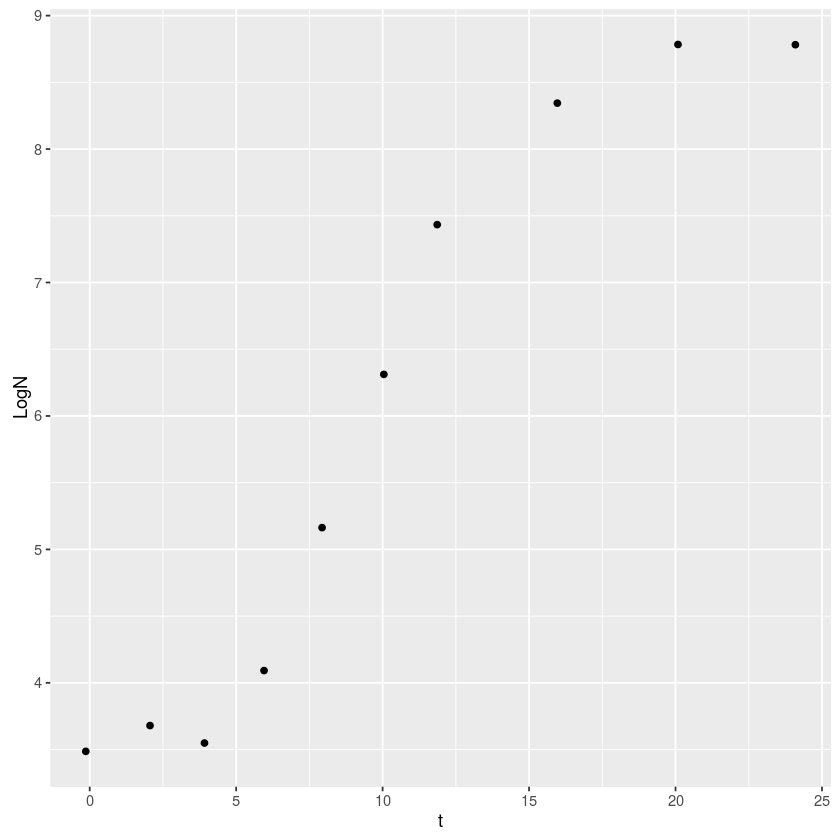

In [22]:
ggplot(data, aes(x = t, y = LogN)) + geom_point()

We will fit three growth models, all of which are known to fit such population growth data, especially in microbes. These are a modified Gompertz model (Zwietering et. al., 1990), the Baranyi model (Baranyi, 1993) and the Buchanan model (or three-phase logistic model; Buchanan, 1997). Given a set of cell numbers (N) and times (t), each growth model can be described in terms of:

$N_0$:  Initial cell culture (Population) density (number of cells per unit volume)  

$N_{max}$: Maximum culture density (aka "carrying capacity") 

$r_{max}$: Maximum growth rate 

$t_{lag}$: Duration of the lag phase before the population starts growing exponentially
   
First let's specify the model functions:

In [23]:
baranyi_model <- function(t, r_max, N_max, N_0, t_lag){  # Baranyi model (Baranyi 1993)
return(N_max + log10((-1+exp(r_max*t_lag) + exp(r_max*t))/(exp(r_max*t) - 1 + exp(r_max*t_lag) * 10^(N_max-N_0))))
}


buchanan_model <- function(t, r_max, N_max, N_0, t_lag){ # Buchanan model - three phase logistic (buchanan 1997)
  return(N_0 + (t >= t_lag) * (t <= (t_lag + (N_max - N_0) * log(10)/r_max)) * r_max * (t - t_lag)/log(10) +
           (t >= t_lag) * (t > (t_lag + (N_max - N_0) * log(10)/r_max)) * (N_max - N_0))
}


gompertz_model <- function(t, r_max, N_max, N_0, t_lag){  # Modified gompertz growth model (Zwietering 1990)
  return(N_0 + (N_max - N_0) * exp(-exp(r_max * exp(1) * (t_lag - t)/((N_max - N_0) * log(10)) + 1)))
}


It is important to note that we have written the funcions in log (to the base 10 - can also be base 2 or natural log) scale. This is because NLLS fitting often converges better in log scale. The interpretation of each of the the estimated/fitted paramters does not change if we take a log of the model's equation.    

Now let's generate some starting values for the NLLS fitting. We did not pay much attention to what starting values we used in the above example on fitting an allometric model because the power-law model is easy to fit using NLLS, and starting far from the optimal parameters does not matter too much. Here, we derive the starting values by using the actual data:  

In [24]:
N_0_start <- min(data$LogN)
N_max_start <- max(data$LogN)
t_lag_start <- data$t[which.max(diff(diff(data$LogN)))]
r_max_start <- max(diff(data$LogN))/mean(diff(data$t))

Now fit the models:

In [25]:
fit_baranyi <- nlsLM(LogN ~ baranyi_model(t = t, r_max, N_max, N_0, t_lag), data,
              list(t_lag=t_lag_start, r_max=r_max_start, N_0 = N_0_start, N_max = N_max_start))

fit_buchanan <- nlsLM(LogN ~ buchanan_model(t = t, r_max, N_max, N_0, t_lag), data,
                        list(t_lag=t_lag_start, r_max=r_max_start, N_0 = N_0_start, N_max = N_max_start))

fit_gompertz <- nlsLM(LogN ~ gompertz_model(t = t, r_max, N_max, N_0, t_lag), data,
                      list(t_lag=t_lag_start, r_max=r_max_start, N_0 = N_0_start, N_max = N_max_start))

Warning message in baranyi_model(t = t, r_max, N_max, N_0, t_lag):
“NaNs produced”Warning message in baranyi_model(t = t, r_max, N_max, N_0, t_lag):
“NaNs produced”Warning message in baranyi_model(t = t, r_max, N_max, N_0, t_lag):
“NaNs produced”

You might get a warning message such as:

`Warning message in baranyi_model(t = t, r_max, N_max, N_0, t_lag):
“NaNs produced”`

This just means that the Baranyi model generated some NaNs during the fitting procedure for the given data. You can ignore it in this case (but not always - sometimes these NaNs mean that the equation is wrongly written, or that it generates NaNs across the whole range of the x-values, in which case the model is inappropriate for these data).     

Get the model summaries:

In [26]:
summary(fit_baranyi)
summary(fit_buchanan)
summary(fit_gompertz)


Formula: LogN ~ baranyi_model(t = t, r_max, N_max, N_0, t_lag)

Parameters:
      Estimate Std. Error t value Pr(>|t|)    
t_lag  5.23445    0.39510   13.25 1.14e-05 ***
r_max  1.34149    0.09418   14.24 7.48e-06 ***
N_0    3.54887    0.09488   37.40 2.44e-08 ***
N_max  8.65373    0.09067   95.45 8.91e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.153 on 6 degrees of freedom

Number of iterations to convergence: 17 
Achieved convergence tolerance: 1.49e-08



Formula: LogN ~ buchanan_model(t = t, r_max, N_max, N_0, t_lag)

Parameters:
      Estimate Std. Error t value Pr(>|t|)    
t_lag  4.13715    0.73469   5.631  0.00134 ** 
r_max  0.99942    0.08768  11.398 2.73e-05 ***
N_0    3.57192    0.16900  21.136 7.31e-07 ***
N_max  8.78296    0.20698  42.433 1.15e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2927 on 6 degrees of freedom

Number of iterations to convergence: 6 
Achieved convergence tolerance: 1.49e-08



Formula: LogN ~ gompertz_model(t = t, r_max, N_max, N_0, t_lag)

Parameters:
      Estimate Std. Error t value Pr(>|t|)    
t_lag  5.47660    0.23460   23.34 4.05e-07 ***
r_max  1.46198    0.07087   20.63 8.44e-07 ***
N_0    3.55900    0.05991   59.41 1.53e-09 ***
N_max  8.84733    0.07520  117.64 2.54e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09735 on 6 degrees of freedom

Number of iterations to convergence: 9 
Achieved convergence tolerance: 1.49e-08


And see how the fits look:

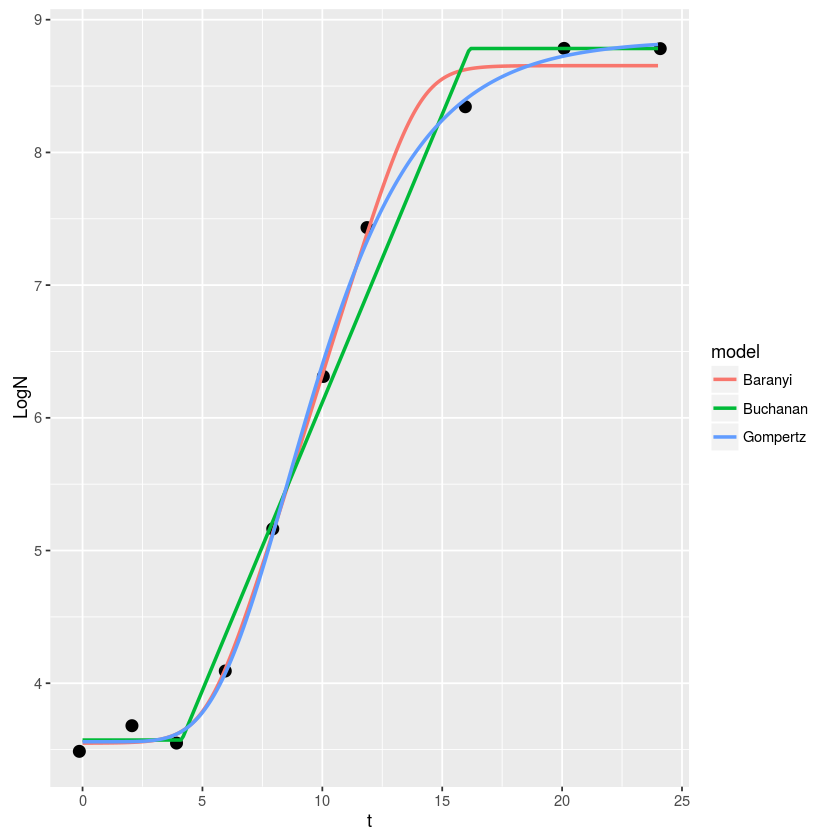

In [27]:
timepoints <- seq(0, 24, 0.1)
baranyi_points <- baranyi_model(t = timepoints, r_max = coef(fit_baranyi)["r_max"], N_max = coef(fit_baranyi)["N_max"],
                                N_0 = coef(fit_baranyi)["N_0"], t_lag = coef(fit_baranyi)["t_lag"])
buchanan_points <- buchanan_model(t = timepoints, r_max = coef(fit_buchanan)["r_max"], N_max = coef(fit_buchanan)["N_max"],
                                N_0 = coef(fit_buchanan)["N_0"], t_lag = coef(fit_buchanan)["t_lag"])
gompertz_points <- gompertz_model(t = timepoints, r_max = coef(fit_gompertz)["r_max"], N_max = coef(fit_gompertz)["N_max"],
                                N_0 = coef(fit_gompertz)["N_0"], t_lag = coef(fit_gompertz)["t_lag"])

df1 <- data.frame(timepoints, baranyi_points)
df1$model <- "Baranyi"
names(df1) <- c("t", "LogN", "model")

df2 <- data.frame(timepoints, buchanan_points)
df2$model <- "Buchanan"
names(df2) <- c("t", "LogN", "model")

df3 <- data.frame(timepoints, gompertz_points)
df3$model <- "Gompertz"
names(df3) <- c("t", "LogN", "model")

model_frame <- rbind(df1, df2, df3)

ggplot(data, aes(x = t, y = LogN)) +
  geom_point(size = 3) +
  geom_line(data = model_frame, aes(x = t, y = LogN, col = model), size = 1)

#### Exercises

(a) Calculate the confidence intervals on the parameters of each of the three fitted models, and use model selection (using AIC and/or BIC) as you did before to find the best-fitting model of the three

(b) Repeat the model comparison exercise 1000 times (You will have to write a loop), and determine whether one model generally wins more often than the others. Note that each run will generate a slightly different dataset, because we are adding a vector of random errors every time the "data" are generated.

(c) Repeat (b), but increase the error by increasing the standard deviation of the normal error distributon, and see if there are differences in the robustness of the models to sampling/experimental errors. You may also want to try changing the distribution of the errors to some non-normal distribution and see what happens.

### Practical

Fit some real data to these models! These data have been generated/collected by [Tom Smith](https://mhasoba.pythonanywhere.com/pawarlab/default/people), a PhD student at Silwood as part of his Dissertation research. Import the [dataset](https://github.com/mhasoba/TheMulQuaBio/blob/master/Data/example_growth_data.csv) into R: 

In [4]:
BacData <- read.csv("../data/example_growth_data.csv")

head(BacData)
tail(BacData)

ID,bacterial_genus,replicate,trait_name,trait_value,hour
Sch_AE103_02,Flavobacterium,1,Log(cells/mL),5.301030,0
Sch_AE103_02,Flavobacterium,1,Log(cells/mL),5.301030,5
Sch_AE103_02,Flavobacterium,1,Log(cells/mL),6.991226,10
Sch_AE103_02,Flavobacterium,1,Log(cells/mL),8.094820,15
Sch_AE103_02,Flavobacterium,1,Log(cells/mL),8.358316,20
Sch_AE103_02,Flavobacterium,1,Log(cells/mL),8.460296,25


,ID,bacterial_genus,replicate,trait_name,trait_value,hour
963,Wil_SP04_02,Bacillus,4,Log(cells/mL),7.086360,25
964,Wil_SP04_02,Bacillus,4,Log(cells/mL),7.322219,30
965,Wil_SP04_02,Bacillus,4,Log(cells/mL),7.361728,35
966,Wil_SP04_02,Bacillus,4,Log(cells/mL),7.322219,40
967,Wil_SP04_02,Bacillus,4,Log(cells/mL),7.260071,45
968,Wil_SP04_02,Bacillus,4,Log(cells/mL),7.292256,50


The column `trait_value` and `hour` are your variables of interest (log cell density and time), respectively. Note that the `ID` column will tell you which rows represent one separate growth experiment.  Make sure you have a good look at the data first by plotting them up (idealy, in a loop).  

* Fit the above population growth rate models, and perform model selection on them. Which model fits best? 
* Can you think of a difefrent model to fit? If so, implement it, and compare that as well. 
* Write the analysis as a single self-standing R script, which will run and return the results in a `*.csv` file and plot(s) ins pdf.
* Again, consider using ggplot insted of base plotting.

## Abundance Time Series

## Readings and Resources <a id='Readings'></a>

* Motulsky, Harvey, and Arthur Christopoulos. Fitting models to biological data using linear and nonlinear regression: a practical guide to curve fitting. OUP USA, 2004.
* Johnson, J. B. & Omland, K. S. 2004 Model selection in ecology and evolution. Trends Ecol. Evol. 19, 101–108.
* The [NCEAS non-linear modelling working group](https://groups.nceas.ucsb.edu/non-linear-modeling/projects/OrangeTree)
* [Mixed-Effects Models in S and S-PLUS](https://link.springer.com/book/10.1007/b98882)
* Also, note that similar to linear models, you can use Non-linear Mixed Effects statistical methods to fit nonlinear models to data (e.g., using the `lme4` and/or `nlme` packages in R).  